In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
columns_to_read = ['YearStart', 'YearEnd', 'LocationDesc', 'Topic', 'Question', 'DataValue']
df = pd.read_csv('/content/drive/MyDrive/SI 670/Final Project/df_filtered.csv', usecols=columns_to_read)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105407 entries, 0 to 105406
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   YearStart     105407 non-null  int64  
 1   YearEnd       105407 non-null  int64  
 2   LocationDesc  105407 non-null  object 
 3   Topic         105407 non-null  object 
 4   Question      105407 non-null  object 
 5   DataValue     71811 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.8+ MB


In [ ]:
## -------------------------------------- old K-means code -----------------------------------------
# grouped_df = df.groupby(['YearStart', 'state', 'condition_description']).sum().reset_index().sort_values(by=['YearStart', 'state', 'total_count'], ascending=[True, True, False])
# top5_conditions_df = grouped_df.groupby(['state', 'YearStart']).apply(lambda x: x.nlargest(5, 'total_count')).reset_index(drop=True)
# top5_conditions_df[:20]
# pivoted_df =  top5_conditions_df.pivot_table(index=['YearStart', 'state'], columns='condition_description', values='total_count', fill_value=0).reset_index().rename_axis(columns=None)
# pivoted_df
# wo_state_df = pivoted_df.drop(columns = ['state'])
# numeric_columns = wo_state_df.columns[wo_state_df.columns != 'YearStart']
# df_numeric = wo_state_df[numeric_columns]
# scaler = StandardScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
# df_scaled = pd.concat([wo_state_df['YearStart'], df_scaled], axis=1)
# df_scaled.shape

In [ ]:
# -------------------------------------- Data preparation for clustering -----------------------------------------
columns_to_read = ['YearStart', 'YearEnd', 'LocationDesc', 'Topic', 'Question', 'DataValue']
df = pd.read_csv('/content/drive/MyDrive/SI 670/Final Project/df_filtered.csv', usecols=columns_to_read)

# rename columns
column_mapping = {
    'LocationDesc': 'state',
    'Topic': 'condition',
    'Question': 'condition_description',
    'DataValue': 'total_count'
}

df = df.rename(columns=column_mapping)

# check states column for anomalies
states_col_values = list(df['state'].unique())
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
    'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia',
    'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

print([element for element in states_col_values if element not in us_states])

# check for # of US values in state column
print(len(df[df['state'] == 'United States']))

# drop rows with United States value in the state column
df = df[df['state'] != 'United States']

# drop rows that are not hospitalization or mortality
drop_cats = ['Life expectancy at age 65 years', 'Number of farmers markets per 100,000 residents',
               'Life expectancy at birth', 'Sale of cigarette packs', 'Gini Index of income inequality']
df = df[~df['condition_description'].isin(drop_cats)]

# check # of values in each categorical column
print('State:',len(df['state'].unique()) , 'Condition:', len(df['condition'].unique()),
      'Condition Description:', len(df['condition_description'].unique()))

df['Diff'] = df['YearStart'] - df['YearEnd']
print(df['Diff'].describe())
# dropping YearEnd col since it's same as YearStart col | dropping condition col as well
df = df.drop(columns = ['Diff', 'YearEnd'])
print('Shape before Imputation and Encoding', df.shape)

# cat_columns = ['state', 'condition', 'condition_description']
# df_encoded = df.copy()

# for column_to_encode in cat_columns:
#   column_values = df_encoded[[column_to_encode]]
#   encoder = OneHotEncoder(sparse_output=False, drop='first')
#   encoded_values = encoder.fit_transform(column_values)
#   new_columns = [f"{column_to_encode}_{i}" for i in range(1, encoded_values.shape[1] + 1)]
#   df_encoded[new_columns] = encoded_values
#   df_encoded.drop(column_to_encode, axis=1, inplace=True)

# imputer = IterativeImputer(random_state=42, max_iter=10)
# imputed_df = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns, index=df_encoded.index)
# X_imputed_non_negative = np.maximum(0, imputed_df)
# print("Shape after imputation:", X_imputed_non_negative.shape)
# df['total_count'] = imputed_df['total_count']
# print(df.head())
# df.to_csv('clustering_dataset.csv', index=False)
# X_imputed_non_negative[X_imputed_non_negative.isnull().any(axis=1)]

['District of Columbia', 'Puerto Rico', 'United States', 'Virgin Islands', 'Guam']
578
State: 54 Condition: 8 Condition Description: 29
count    102750.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Diff, dtype: float64
Shape before Imputation and Encoding (102750, 5)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SI 670/Final Project/clustering_dataset.csv')
len(df[df['total_count'] < 0])

0

In [ ]:
df[df.isnull().any(axis=1)]

,YearStart,state,condition,condition_description,total_count


In [ ]:
df.head()

,YearStart,state,condition,condition_description,total_count
0,2010,Oregon,Cardiovascular Disease,Mortality from heart failure,30.0
1,2011,Alaska,Alcohol,Chronic liver disease mortality,99.0
2,2016,Alaska,Alcohol,Chronic liver disease mortality,58.0
3,2019,Alaska,Alcohol,Chronic liver disease mortality,110.0
4,2016,Alabama,Alcohol,Chronic liver disease mortality,118.0


In [ ]:
grouped_states = df.groupby(['state', 'condition_description']).sum(numeric_only=True).reset_index().sort_values(by=['state', 'total_count'], ascending=[True, False]).drop(columns = ['YearStart'])
pivot_states = grouped_states.pivot_table(index = ['state'], columns = ['condition_description'], values = 'total_count', fill_value=0).reset_index().rename_axis(columns=None)

In [ ]:
pivot_states.shape

(54, 30)

In [ ]:
pivot_states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 30 columns):
 #   Column                                                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                                                --------------  -----  
 0   state                                                                                                                                 54 non-null     object 
 1   Amputation of a lower extremity attributable to diabetes                                                                              54 non-null     float64
 2   Asthma mortality rate                                                                                                                 54 non-null     float64
 3   Chronic liver disease mortality                                              

In [ ]:
# df.groupby(['state', 'condition_description']).sum(numeric_only=True).reset_index().sort_values(by=['state', 'total_count'], ascending=[True, False]).drop(columns = ['YearStart'])
# pivot_states
wo_state_df = pivot_states.drop(columns = ['state'])
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(wo_state_df), columns=wo_state_df.columns)
df_scaled.shape

(54, 29)

In [ ]:
df_scaled.head()

,Amputation of a lower extremity attributable to diabetes,Asthma mortality rate,Chronic liver disease mortality,Emergency department visit rate for asthma,Emergency department visit rate for chronic obstructive pulmonary disease as any diagnosis,Emergency department visit rate for chronic obstructive pulmonary disease as first-listed diagnosis,Hospitalization for acute myocardial infarction,Hospitalization for chronic obstructive pulmonary disease as any diagnosis,Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years,Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis,...,Mortality from cerebrovascular disease (stroke),Mortality from coronary heart disease,Mortality from diseases of the heart,Mortality from heart failure,Mortality from total cardiovascular diseases,Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years,Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years,Mortality with diabetic ketoacidosis reported as any listed cause of death,Mortality with end-stage renal disease,Premature mortality among adults aged 45-64 years
0,-0.127626,-0.365375,-0.210852,0.030100,-0.130856,-0.065062,-0.031993,-0.149198,0.054908,-0.047351,...,0.213810,0.015171,0.115337,0.227998,0.050193,0.269637,0.309299,-0.380835,0.132038,0.153824
1,-0.620670,-0.389879,-0.600801,-0.610562,-0.304210,-0.681339,-0.992291,-0.694075,-0.870697,-0.966864,...,-0.775609,-0.837159,-0.904286,-0.927995,-0.888737,-0.880311,-0.949529,-0.486353,-0.857849,-0.869356
2,-0.226708,-0.352049,-0.185477,-0.083817,0.122189,-0.033888,0.078384,0.068326,-0.118441,-0.201681,...,-0.184625,0.019518,-0.073455,-0.206163,-0.050875,-0.036258,-0.018436,-0.331185,-0.211185,0.028923
3,-0.472291,-0.379079,-0.480765,-0.823398,-0.811812,-0.636488,-0.395987,-0.328222,-0.413972,-0.281042,...,-0.406408,-0.313188,-0.304621,-0.378382,-0.315524,-0.373359,-0.394587,-0.401894,-0.417268,-0.317906
4,4.499295,1.531944,1.488519,2.537398,1.426956,2.458567,3.429017,1.220544,2.764279,2.946540,...,3.039350,3.723904,3.761611,3.867889,4.006907,2.418755,3.395401,2.041722,3.838270,3.792178


In [ ]:
pivot_states

,state,Amputation of a lower extremity attributable to diabetes,Asthma mortality rate,Chronic liver disease mortality,Emergency department visit rate for asthma,Emergency department visit rate for chronic obstructive pulmonary disease as any diagnosis,Emergency department visit rate for chronic obstructive pulmonary disease as first-listed diagnosis,Hospitalization for acute myocardial infarction,Hospitalization for chronic obstructive pulmonary disease as any diagnosis,Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years,...,Mortality from cerebrovascular disease (stroke),Mortality from coronary heart disease,Mortality from diseases of the heart,Mortality from heart failure,Mortality from total cardiovascular diseases,Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years,Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years,Mortality with diabetic ketoacidosis reported as any listed cause of death,Mortality with end-stage renal disease,Premature mortality among adults aged 45-64 years
0,Alabama,62834.316097,1756.000000,34448.900096,6.452542e+05,2.205715e+06,5.279800e+05,203436.202913,1.271502e+06,1.778588e+06,...,133901.321480,2.491469e+05,4.629841e+05,2.731231e+05,5.701803e+05,150701.749762,259465.182048,9428.000000,180423.297640,3.925605e+05
1,Alaska,1102.000000,0.000000,3467.000000,3.968612e+05,1.978922e+06,3.011864e+05,6404.000000,6.834789e+05,2.612218e+05,...,5990.000000,1.424400e+04,2.787414e+04,1.265000e+04,4.658070e+04,6135.000000,13283.000000,534.000000,9736.000000,3.910800e+04
2,Arizona,50428.553669,2711.000000,36465.000000,6.010870e+05,2.536765e+06,5.394520e+05,226083.000000,1.506252e+06,1.494414e+06,...,82392.000000,2.503450e+05,3.824200e+05,1.752960e+05,5.138190e+05,112245.915727,195371.799525,13613.000000,121241.000000,3.494140e+05
3,Arkansas,19680.000000,774.000000,13004.000000,3.143420e+05,1.314845e+06,3.176916e+05,128752.638643,1.078302e+06,1.009942e+06,...,53720.000000,1.586509e+05,2.837729e+05,1.364910e+05,3.662359e+05,69867.000000,121810.000000,7653.000000,85706.000000,2.296036e+05
4,California,642155.038489,137721.789486,169466.000000,1.617367e+06,4.243747e+06,1.456691e+06,913559.261334,2.749708e+06,6.220126e+06,...,499185.000000,1.271277e+06,2.018981e+06,1.093278e+06,2.776663e+06,420880.000000,862998.000000,213622.524411,819493.000000,1.649411e+06
5,Colorado,22939.000000,1360.000000,25736.000000,4.659179e+05,1.972023e+06,3.643806e+05,125173.367535,8.860190e+05,8.889930e+05,...,60023.000000,1.229062e+05,2.289770e+05,1.544300e+05,3.149200e+05,77665.000000,162850.000000,10643.000000,100260.000000,2.404510e+05
6,Connecticut,0.000000,1006.000000,12276.000000,5.543445e+05,2.122711e+06,4.449755e+05,120431.736119,1.188498e+06,1.018491e+06,...,44431.000000,1.416029e+05,2.755369e+05,1.416153e+05,3.598059e+05,43554.000000,105333.924473,4868.000000,84527.917237,1.955983e+05
7,Delaware,1258.000000,0.000000,3192.000000,4.442303e+05,2.022172e+06,3.444364e+05,21105.726806,9.386588e+05,5.161661e+05,...,16365.000000,3.851100e+04,8.792218e+04,2.975400e+04,1.264338e+05,15350.000000,30042.000000,1495.000000,24470.000000,6.120583e+04
8,District of Columbia,4614.000000,0.000000,1500.000000,3.753819e+05,1.959310e+06,2.815748e+05,11332.000000,4.073422e+05,4.592594e+05,...,7522.000000,2.517100e+04,4.215200e+04,1.281300e+04,7.674152e+04,4413.000000,9818.000000,1140.000000,12736.000000,4.228500e+04
9,Florida,300340.273965,428334.900212,446659.576532,1.997710e+06,9.898755e+06,2.361393e+06,917145.000000,7.556076e+06,7.398070e+06,...,616397.853318,9.801388e+05,1.477613e+06,7.544648e+05,1.993663e+06,528529.785027,739413.105570,480940.030778,620541.704041,1.171802e+06


In [ ]:
reshaped = pivot_states.melt(id_vars=pivot_states.columns[0], var_name='Column', value_name='Value')
reshaped.shape

(1566, 3)

In [ ]:
sorted_df = reshaped.sort_values(by=['state', 'Value'], ascending=[True, False]).reset_index(drop=True)
sorted_df.shape

(1566, 3)

In [ ]:
top5_cdi = sorted_df.groupby('state').head(5).drop(columns = ['Value'])
top5_cdi['Rank'] = top5_cdi.groupby('state').cumcount() + 1
top5_cdi = top5_cdi.pivot(index='state', columns='Rank', values='Column')
column_names = ['1st most common cdi', '2nd most common cdi', '3rd most common cdi', '4th most common cdi', '5th most common cdi']
top5_cdi.columns = column_names
top5_cdi = top5_cdi.reset_index()

In [ ]:
top5_cdi

,state,1st most common cdi,2nd most common cdi,3rd most common cdi,4th most common cdi,5th most common cdi
0,Alabama,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
1,Alaska,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma,Emergency department visit rate for chronic ob...
2,Arizona,Hospitalization with diabetes as a listed diag...,Emergency department visit rate for chronic ob...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
3,Arkansas,Hospitalization with diabetes as a listed diag...,Emergency department visit rate for chronic ob...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Mortality from total cardiovascular diseases
4,California,Hospitalization for chronic obstructive pulmon...,Hospitalization with diabetes as a listed diag...,Emergency department visit rate for chronic ob...,Mortality from total cardiovascular diseases,Hospitalization for chronic obstructive pulmon...
5,Colorado,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
6,Connecticut,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
7,Delaware,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
8,District of Columbia,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma
9,Florida,Hospitalization with diabetes as a listed diag...,Emergency department visit rate for chronic ob...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for chronic ob...


## Modeling

In [ ]:
k_values = range(1, 16)

for k in k_values:
    kmeans = KMeans(n_init = 10, n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    if len(set(labels)) > 1:
      silhouette_avg = silhouette_score(df_scaled, labels)
      print(f'Silhouette Score for K={k}: {silhouette_avg}')

Silhouette Score for K=2: 0.6666546296786107
Silhouette Score for K=3: 0.5287426157127678
Silhouette Score for K=4: 0.533886031585398
Silhouette Score for K=5: 0.4587880392032385
Silhouette Score for K=6: 0.46740614666183156
Silhouette Score for K=7: 0.4527810895591482
Silhouette Score for K=8: 0.41187613397194045
Silhouette Score for K=9: 0.3097809421509459
Silhouette Score for K=10: 0.39192902636727706
Silhouette Score for K=11: 0.37607080751568556
Silhouette Score for K=12: 0.37557040646436307
Silhouette Score for K=13: 0.36478668672524395
Silhouette Score for K=14: 0.3629552872402681
Silhouette Score for K=15: 0.338375228977683


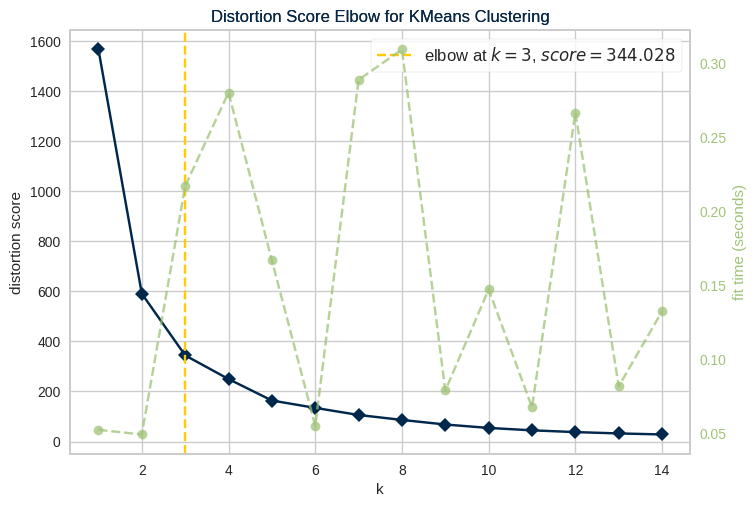

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(n_init = 10, random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 15), colors='blue')
visualizer.fit(df_scaled)

line1,line2 = visualizer.ax.lines[0], visualizer.ax.lines[1]
line1.set_color('#00274C')
line2.set_color('#FFCB05')
plt.title('Distortion Score Elbow for KMeans Clustering', color='#00274C')
plt.grid(False)
plt.savefig('customized_elbow_plot.png', dpi=300)
visualizer.show()

In [ ]:
# from yellowbrick.cluster import SilhouetteVisualizer

# clf = KMeans(n_init=10, n_clusters=3)
# vzr = SilhouetteVisualizer(clf)
# vzr.fit(df_scaled)
# vzr.poof()

model = KMeans(n_init = 10, n_clusters = 3, random_state=42)
# visualizer.fit(df_scaled)
df_scaled['Cluster'] = model.fit_predict(df_scaled)

In [ ]:
top5_cdi.insert(0, 'Cluster Labels', model.labels_)

In [ ]:
top5_cdi['state']

0                  Alabama
1                   Alaska
2                  Arizona
3                 Arkansas
4               California
5                 Colorado
6              Connecticut
7                 Delaware
8     District of Columbia
9                  Florida
10                 Georgia
11                    Guam
12                  Hawaii
13                   Idaho
14                Illinois
15                 Indiana
16                    Iowa
17                  Kansas
18                Kentucky
19               Louisiana
20                   Maine
21                Maryland
22           Massachusetts
23                Michigan
24               Minnesota
25             Mississippi
26                Missouri
27                 Montana
28                Nebraska
29                  Nevada
30           New Hampshire
31              New Jersey
32              New Mexico
33                New York
34          North Carolina
35            North Dakota
36                    Ohio
3

In [ ]:
state_coordinates = {
    'Alabama': (32.806671, -86.791130),
    'Alaska': (61.016023, -149.737612),
    'Arizona': (33.729759, -111.431221),
    'Arkansas': (34.969704, -92.373123),
    'California': (36.778259, -119.417931),
    'Colorado': (39.550051, -105.782067),
    'Connecticut': (41.603221, -73.087749),
    'Delaware': (38.910832, -75.527670),
    'District of Columbia': (38.895110, -77.036370),
    'Florida': (27.994402, -81.760254),
    'Georgia': (33.040619, -83.643074),
    'Guam': (13.444304, 144.793731),
    'Hawaii': (20.796137, -156.331924),
    'Idaho': (44.068202, -114.742041),
    'Illinois': (40.633125, -89.398528),
    'Indiana': (40.551217, -85.602364),
    'Iowa': (41.878002, -93.097702),
    'Kansas': (39.011902, -98.484246),
    'Kentucky': (37.839333, -84.270020),
    'Louisiana': (31.244823, -92.145024),
    'Maine': (45.253783, -69.445469),
    'Maryland': (39.045753, -76.641273),
    'Massachusetts': (42.407211, -71.382439),
    'Michigan': (44.314844, -85.602364),
    'Minnesota': (46.729553, -94.685900),
    'Mississippi': (32.354668, -89.398528),
    'Missouri': (37.964253, -91.831833),
    'Montana': (46.879682, -110.362566),
    'Nebraska': (41.492537, -99.901813),
    'Nevada': (38.802610, -116.419389),
    'New Hampshire': (43.193852, -71.572395),
    'New Jersey': (40.058324, -74.405661),
    'New Mexico': (34.972730, -105.032363),
    'New York': (43.299428, -74.217933),
    'North Carolina': (35.759573, -79.019300),
    'North Dakota': (47.551493, -101.002012),
    'Ohio': (40.417287, -82.907123),
    'Oklahoma': (35.007752, -97.092877),
    'Oregon': (43.804133, -120.554201),
    'Pennsylvania': (41.203322, -77.194525),
    'Puerto Rico': (18.220833, -66.590149),
    'Rhode Island': (41.580095, -71.477429),
    'South Carolina': (33.836081, -81.163725),
    'South Dakota': (43.969515, -99.901813),
    'Tennessee': (35.517491, -86.580447),
    'Texas': (31.968599, -99.901813),
    'United States': (37.090240, -95.712891),
    'Utah': (39.320980, -111.093731),
    'Vermont': (44.558803, -72.577841),
    'Virgin Islands': (18.335765, -64.896335),
    'Virginia': (37.769337, -78.169968),
    'Washington': (47.400902, -121.490494),
    'West Virginia': (38.597626, -80.454903),
    'Wisconsin': (43.784440, -88.787868),
    'Wyoming': (43.075968, -107.290284)
}

In [ ]:
top5_cdi['Latitude'] = top5_cdi['state'].map(lambda x: state_coordinates[x][0])
top5_cdi['Longitude'] = top5_cdi['state'].map(lambda x: state_coordinates[x][1])

In [ ]:
top5_cdi.head(2)

,Cluster Labels,state,1st most common cdi,2nd most common cdi,3rd most common cdi,4th most common cdi,5th most common cdi,Latitude,Longitude
0,0,Alabama,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma,32.806671,-86.791130
1,2,Alaska,Emergency department visit rate for chronic ob...,Hospitalization with diabetes as a listed diag...,Hospitalization for chronic obstructive pulmon...,Emergency department visit rate for asthma,Emergency department visit rate for chronic ob...,61.016023,-149.737612


In [ ]:
import folium
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from folium.plugins import MarkerCluster

map_center = [top5_cdi['Latitude'].mean(), top5_cdi['Longitude'].mean()]

map_clusters = folium.Map(location=map_center, zoom_start=4)

# Set color scheme for the clusters
colors = ['#9A3324', '#FFCB05', '#00274C']

# Add markers to the map
for lat, lon, state, cluster in zip(top5_cdi['Latitude'], top5_cdi['Longitude'], top5_cdi['state'], top5_cdi['Cluster Labels']):
    label = folium.Popup(f"{state} - Cluster {cluster}", parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        icon=folium.Icon(color='white', icon_color=colors[cluster-1]),
        color=colors[cluster-1],
        fill=True,
        fill_color=colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

# Display the map
map_clusters

In [ ]:
top5_cdi['count'] = summed['total_count']
top5_cdi[['Cluster Labels', 'state', 'count']].sort_values('Cluster Labels').to_csv('sorted.csv',index=False)

In [ ]:
top5_cdi[['Cluster Labels', 'state']].to_dict()

{'Cluster Labels': {0: 0,
  1: 2,
  2: 2,
  3: 0,
  4: 1,
  5: 0,
  6: 0,
  7: 0,
  8: 2,
  9: 1,
  10: 2,
  11: 2,
  12: 2,
  13: 0,
  14: 1,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 2,
  20: 0,
  21: 2,
  22: 2,
  23: 2,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 2,
  30: 0,
  31: 2,
  32: 2,
  33: 1,
  34: 1,
  35: 0,
  36: 1,
  37: 2,
  38: 0,
  39: 1,
  40: 2,
  41: 2,
  42: 2,
  43: 2,
  44: 0,
  45: 1,
  46: 2,
  47: 2,
  48: 2,
  49: 0,
  50: 2,
  51: 0,
  52: 2,
  53: 0},
 'state': {0: 'Alabama',
  1: 'Alaska',
  2: 'Arizona',
  3: 'Arkansas',
  4: 'California',
  5: 'Colorado',
  6: 'Connecticut',
  7: 'Delaware',
  8: 'District of Columbia',
  9: 'Florida',
  10: 'Georgia',
  11: 'Guam',
  12: 'Hawaii',
  13: 'Idaho',
  14: 'Illinois',
  15: 'Indiana',
  16: 'Iowa',
  17: 'Kansas',
  18: 'Kentucky',
  19: 'Louisiana',
  20: 'Maine',
  21: 'Maryland',
  22: 'Massachusetts',
  23: 'Michigan',
  24: 'Minnesota',
  25: 'Mississippi',
  26: 'Missouri',
  27: 'Montana',
 

In [ ]:
summed = df.groupby('state').sum(numeric_only=True).drop(columns=['YearStart']).reset_index()

min_value = summed['total_count'].min()
max_value = summed['total_count'].max()
summed['total_count'] = round(1 + 99 * ((summed['total_count'] - min_value) / (max_value - min_value)))

In [ ]:
summed['total_count']

0      19.0
1       5.0
2      20.0
3      11.0
4      68.0
5      11.0
6      13.0
7       8.0
8       4.0
9     100.0
10     29.0
11      9.0
12      4.0
13      9.0
14     32.0
15     21.0
16      9.0
17     11.0
18     27.0
19     16.0
20     10.0
21     18.0
22     21.0
23     41.0
24     12.0
25     14.0
26     21.0
27      9.0
28     10.0
29      7.0
30     10.0
31     33.0
32      6.0
33     64.0
34     40.0
35      9.0
36     36.0
37     16.0
38     10.0
39     39.0
40      9.0
41      1.0
42     19.0
43      4.0
44     24.0
45     47.0
46      6.0
47      2.0
48      9.0
49     21.0
50     17.0
51     13.0
52     17.0
53      8.0
Name: total_count, dtype: float64